In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV as gs
import graphviz 

In [3]:
stress = pd.read_csv('sleep_stress.csv')
stress_test=stress.copy()
stress_test.columns = ["snoring_rage", "respiration_rate", "body_temperature", "limb_movement_rate", "blood_oxygen_levels", "eye_movement", "number_of_hours_of_sleep", "heart_rate","Stress_Levels" ]
stress_test.loc[stress_test['Stress_Levels'] >=1, 'Stress_Levels'] = 1


In [4]:
#불균형 문제 해소
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
smote = SMOTE()
X = stress_test.iloc[:,:8]
Y = stress_test["Stress_Levels"]
x, y = smote.fit_resample(X, Y)
print(sorted(Counter(y).items()))
stress_b = pd.DataFrame(x, columns=x.columns)
stress_clue = y.to_frame()
# st = pd.concat([stress_b, stress_clue],join="outer")
st = stress_b.join(stress_clue)
st.head()

[(0, 504), (1, 504)]


,snoring_rage,respiration_rate,body_temperature,limb_movement_rate,blood_oxygen_levels,eye_movement,number_of_hours_of_sleep,heart_rate,Stress_Levels
0,93.80,25.680,91.840,16.600,89.840,99.60,1.840,74.20,1
1,91.64,25.104,91.552,15.880,89.552,98.88,1.552,72.76,1
2,60.00,20.000,96.000,10.000,95.000,85.00,7.000,60.00,1
3,85.76,23.536,90.768,13.920,88.768,96.92,0.768,68.84,1
4,48.12,17.248,97.872,6.496,96.248,72.48,8.248,53.12,0


Area Under the Curve (AUC):  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00       101

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



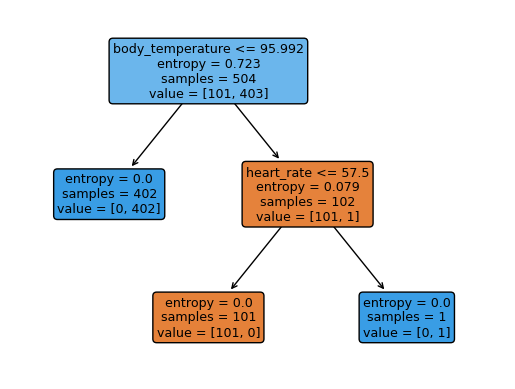

In [5]:
from sklearn.metrics import classification_report, roc_curve, auc
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size=0.2)
treee = sklearn.tree.DecisionTreeClassifier(criterion="entropy")
treee.fit(xtrain, ytrain)
out = sklearn.tree.plot_tree(treee, feature_names=X.columns, filled=True, rounded=True)
Y_pred=treee.predict(xtest)
fpr, tpr, thresholds = roc_curve(ytest, Y_pred)
print("Area Under the Curve (AUC): ",auc(fpr, tpr))
print(classification_report(ytest, Y_pred))

In [7]:
#st = dataframe
feat = st.columns.values.tolist()
def colorDT(clf, feat):
  def make_col(tree, node):
    if tree.tree_.value[node][0][0]>tree.tree_.value[node][0][1]:
      col="#e68938"
    elif tree.tree_.value[node][0][0]==tree.tree_.value[node][0][1]:
      col="grey"
    else:
      col="#00bfff"
    return col
#define edge colors
  def make_col_edge(node, right=True):
    if not right:
      if (clf.tree_.value[clf.tree_.children_left[i]][0][0]/(clf.tree_.value[clf.tree_.children_left[i]][0][0]+clf.tree_.value[clf.tree_.children_left[i]][0][1])) > clf.tree_.value[i][0][0]/(clf.tree_.value[i][0][0]+clf.tree_.value[i][0][1]):
        col="red"
      else:
        col="blue"
    if right:
      if (clf.tree_.value[clf.tree_.children_right[i]][0][0]/(clf.tree_.value[clf.tree_.children_right[i]][0][0]+clf.tree_.value[clf.tree_.children_right[i]][0][1])) > clf.tree_.value[i][0][0]/(clf.tree_.value[i][0][0]+clf.tree_.value[i][0][1]):
        col="red"
      else:
        col="blue"
    return col
  Tree = graphviz.Graph('tree', format='svg') 
  Tree.edge_attr.update(dir="forward")
  Tree.edge_attr.update(arrowhead="vee")
  Tree.node_attr.update(shape="cylinder")
  node = clf.tree_.node_count
  nodes=np.arange(0, node, 1)
  for i in nodes:
    parent = f'{feat[clf.tree_.feature[i]]}<={round(clf.tree_.threshold[i],3)}\nentropy={round(clf.tree_.impurity[i],3)}\nvalue={clf.tree_.value[i][0]}'
    if clf.tree_.children_left[i]!=-1:
      if clf.tree_.children_left[clf.tree_.children_left[i]]!=-1:
          left = f'{feat[clf.tree_.feature[clf.tree_.children_left[i]]]}<={round(clf.tree_.threshold[clf.tree_.children_left[i]],3)}\nentropy={round(clf.tree_.impurity[clf.tree_.children_left[i]],3)}\nvalue={clf.tree_.value[clf.tree_.children_left[i]][0]}'
      else: 
        left = f'entropy={round(clf.tree_.impurity[clf.tree_.children_left[i]],3)}\nvalue={clf.tree_.value[clf.tree_.children_left[i]][0]}'
        Tree.node(left, style='filled', color=make_col(clf, clf.tree_.children_left[i]), shape='rect')
      if clf.tree_.impurity[i]>clf.tree_.impurity[clf.tree_.children_left[i]]:
        Tree.node(parent, style='filled', color=make_col(clf, i))
        Tree.edge(parent, left, color=make_col_edge(i,right=False))
        Tree.edge(parent, left, color=make_col_edge(i,right=False))
      else:
        Tree.node(parent, style='filled', color=make_col(clf, i))
        Tree.edge(parent, left, color=make_col_edge(i,right=False))
    if clf.tree_.children_right[i]!=-1:
      if clf.tree_.children_left[clf.tree_.children_right[i]]!=-1:
        right = f'{feat[clf.tree_.feature[clf.tree_.children_right[i]]]}<={round(clf.tree_.threshold[clf.tree_.children_right[i]],3)}\nentropy={round(clf.tree_.impurity[clf.tree_.children_right[i]],3)}\nvalue={clf.tree_.value[clf.tree_.children_right[i]][0]}'
      else: 
        right = f'entropy={round(clf.tree_.impurity[clf.tree_.children_right[i]],3)}\nvalue={clf.tree_.value[clf.tree_.children_right[i]][0]}'
        Tree.node(right, style='filled', color=make_col(clf, clf.tree_.children_right[i]), shape='rect')
      if clf.tree_.impurity[i]>clf.tree_.impurity[clf.tree_.children_right[i]]:
        Tree.edge(parent, right, color=make_col_edge(i,right=True))
        Tree.edge(parent, right, color=make_col_edge(i,right=True))
      else:
        Tree.edge(parent, right, color=make_col_edge(i,right=True))
  return Tree

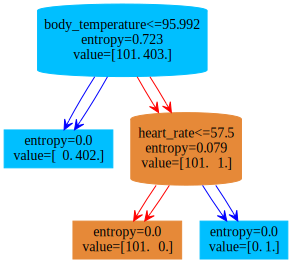

In [9]:
a = colorDT(treee, feat)
a